In [120]:
import os
import cv2
import time
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import style
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

In [2]:
REBUILD_DATA = False

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "/Users/abdullahkarakus/Documents/Github/kagglecatsanddogs_3367a/PetImages/Cat"    
    DOGS = "/Users/abdullahkarakus/Documents/Github/kagglecatsanddogs_3367a/PetImages/Dog" 
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                
                except Exception as e:
                    pass
               
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)


        
if REBUILD_DATA:
    dogsvcats = DogsVSCats() 
    dogsvcats.make_training_data()

/Users/abdullahkarakus/Documents/Github/kagglecatsanddogs_3367a/PetImages/Cat


  0%|          | 0/12502 [00:00<?, ?it/s]

Corrupt JPEG data: 217 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1158 extraneous bytes before marker 0xd9
Corrupt JPEG data: 104 extraneous bytes before marker 0xd9
Corrupt JPEG data: 133 extraneous bytes before marker 0xd9
Corrupt JPEG data: 242 extraneous bytes before marker 0xd9


/Users/abdullahkarakus/Documents/Github/kagglecatsanddogs_3367a/PetImages/Dog


  0%|          | 0/12501 [00:00<?, ?it/s]

Corrupt JPEG data: 70 extraneous bytes before marker 0xd9
Corrupt JPEG data: 232 extraneous bytes before marker 0xd9
Corrupt JPEG data: 164 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2232 extraneous bytes before marker 0xd9
Corrupt JPEG data: 259 extraneous bytes before marker 0xd9
Corrupt JPEG data: 402 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1408 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
/Users/abdullahkarakus/opt/anaconda3/envs/pyt/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470


In [2]:
data = np.load("training_data.npy", allow_pickle = True)

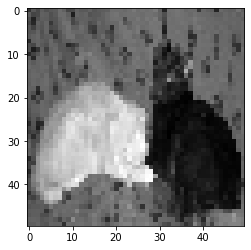

In [87]:
plt.imshow(training_data[0][0], cmap = "gray")
plt.show()

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(128*2*2,512)
        self.fc2 = nn.Linear(512,2)
    
    # output = ((input - kernel_size + 2*padding) / stride) + 1
    
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2,2))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return F.softmax(x, dim =1)

In [4]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [5]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

In [6]:
training_size = int(0.8*len(data))
test_size = len(data) - training_size

training_data, test_data = random_split(data, [training_size, test_size], generator = torch.Generator().manual_seed(50))

In [53]:
X_train = torch.tensor([i[0] for i in training_data]) 
y_train = torch.tensor([i[1] for i in training_data])

X_test = torch.tensor([i[0] for i in test_data]) 
y_test = torch.tensor([i[1] for i in test_data])

X_train = X_train / 255.0
X_test = X_test / 255.0

In [69]:
y= y_train[0:100]

In [80]:
z = y.view(-1,1,2)
z[0]

tensor([[1., 0.]], dtype=torch.float64)

In [103]:
batch_size = 8
epochs = 3

for epoch in range(epochs):
    for i in tqdm(range(0, len(X_train), batch_size)):
        X_batch = X_train[i:i+8].view(-1,1,50,50)
        y_batch = y_train[i:i+8]
        
        net.zero_grad()
        outputs = net(X_batch)
        loss = loss_function(outputs, y_batch.float())
        loss.backward()
        optimizer.step()

print(loss)

  0%|          | 0/2495 [00:00<?, ?it/s]

  0%|          | 0/2495 [00:00<?, ?it/s]

  0%|          | 0/2495 [00:00<?, ?it/s]

tensor(0.0754, grad_fn=<MseLossBackward>)


In [104]:
total = 0 
count = 0

with torch.no_grad():
    for i in tqdm(range(len(X_test))):
        real_class = torch.argmax(y_test[i])
        net_out = net(X_test[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            count += 1
        total += 1

  0%|          | 0/4990 [00:00<?, ?it/s]

In [105]:
print("accuracy:", round(count/total, 3))

accuracy: 0.772


In [111]:
def fwd_pass(X, y, train = False):
    if train:
        net.zero_grad()
    
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i,j in zip(outputs,y)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs,y)
    
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [114]:
def test(size = 32):
    
    random_start = np.random.randint(len(X_test)-size)
    X_val, y_val = X_test[random_start:random_start + size], y_test[random_start:random_start + size]
   
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X_val.view(-1,1,50,50),y_val)
    
    return val_acc, val_loss
    
    

In [119]:
MODEL_NAME = f"model.{int(time.time())}"

net = Net()

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

def train():
    BATCH_SIZE = 64
    EPOCHS = 5
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0,len(X_train), BATCH_SIZE)):
                X_batch = X_train[i:i+BATCH_SIZE].view(-1,1,50,50)
                y_batch = y_train[i:i+BATCH_SIZE].float()
                
                acc, loss = fwd_pass(X_batch, y_batch, train = True)
                if i % 50 == 0:
                    val_acc, val_loss = test(size = 32)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")

train()

model.1637985878


  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

In [129]:
style.use("ggplot")

model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")
    
    times = []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []
    
    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
            
            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))
            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))
    
    return times,accuracies,losses,val_accs,val_losses


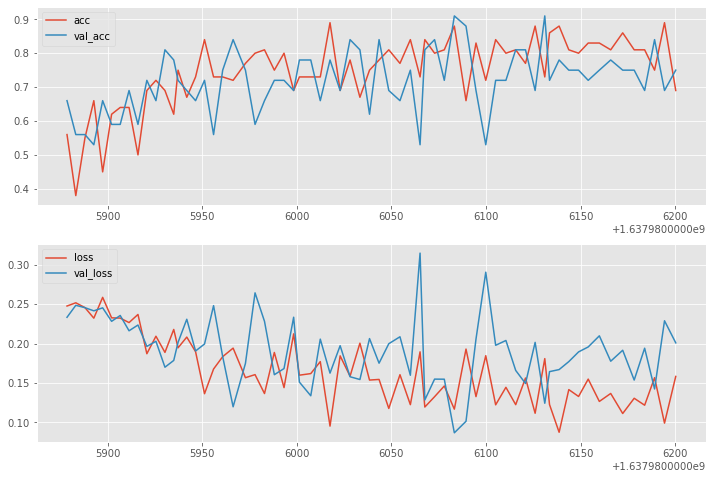

In [143]:
times,accuracies,losses,val_accs,val_losses = create_acc_loss_graph(model_name)

fig = plt.figure(figsize = (12,8))

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0))

ax1.plot(times,accuracies, label = "acc")
ax1.plot(times,val_accs, label = "val_acc")
ax1.legend(loc = 2)

ax2.plot(times, losses, label = "loss")
ax2.plot(times, val_losses, label = "val_loss")
ax2.legend(loc = 2)

plt.show()